# EVAC Examination

## Data Exploration

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [200]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 64
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) +(numHiddenNodes1 * numOutputNodes)



/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_79663/3200560116.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [201]:
data = pd.read_csv('eScooterDemand.csv')
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


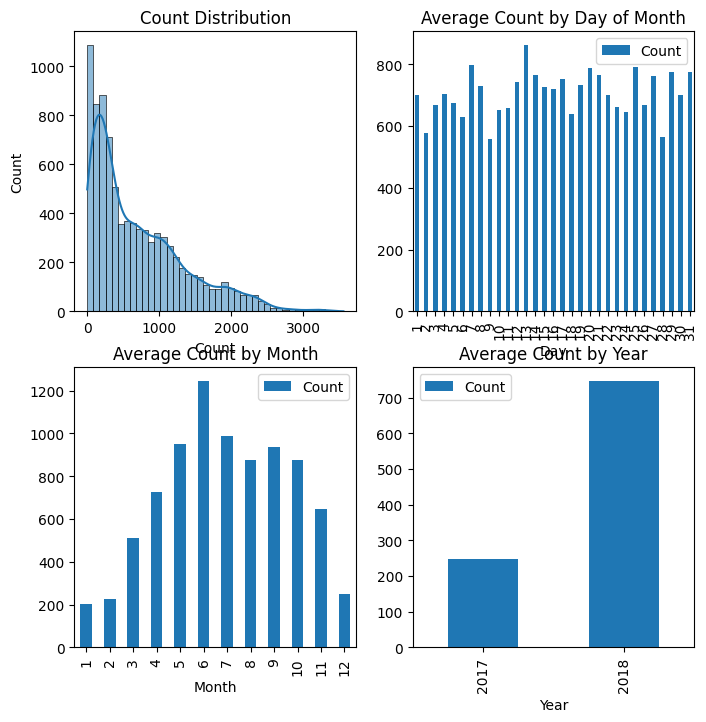

In [202]:


## plot average count over time to look for patterns that can be used to predict future demand
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')
plt.show()


In [203]:
data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [204]:
!pip install deap

In [205]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator


In [206]:
## Prepare data for training
data['Windspeed'] = data['Wind speed']
data['HireAvailable'] = data['HireAvailable'].map({'Yes': 1, 'No': 0})
data['PublicHoliday'] = data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
data['Weekend'] = data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
data['Season'] = data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [207]:
data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [208]:

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans
    
    def feedForward(self, inputs):
      inputsBias = inputs[:]
      inputsBias.insert(len(inputs),1)                 # Add bias input
      h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
      h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
      output = np.dot(self.wo, h1)                 # feed to output layer
      # output = [self.sigmoid(x) for x in output]   # Activate output layer
      return output
    
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

myNet = MLP(numInputNodes, numHiddenNodes1, numOutputNodes)



In [209]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [210]:
import numpy
# randomise data
data = data.sample(frac=1).reset_index(drop=True)
data = data[:500]
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


In [211]:
def eval(individual, myNet):
  myNet.setWeightsLinear(individual)
  fitness = 0
  for i in range(len(data)):
    input = [ data['Windspeed'][i], data['Visibility'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i], data['Hour'][i], data['Temp'][i]]
    output = myNet.feedForward(input)
    if output[0] < 0:
      return 1000000000000000,
    fitness += abs(output[0] - data['Count'][i])
  return fitness,


In [212]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.5)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

baseline = toolbox.evaluate(myNet.getWeightsLinear(), myNet)
print(baseline)

(1000000000000000,)


In [213]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [214]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
ind.fitness.values = toolbox.evaluate(ind, myNet)
print(ind.fitness.valid)
print(myNet.setWeightsLinear(ind))
print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet))

[0.09772193792094308, 0.807684054202924, -0.03902479994985697, 0.7297216948457061, 0.9668240938854991, -0.7285118140598219, -0.356720425163533, -0.7274905873701742, 0.18188273792462284, 0.39651218415499034, -0.6416179854618795, -0.7749102960604588, 0.6958060449975247, -0.1770902592594359, 0.36909968946760596, 0.22260014824960694, 0.45644980091741916, -0.5171590752458759, 0.1889139869535148, -0.8954802647084872, -0.37558505077231397, -0.5569710016193086, -0.11153247614210104, 0.11842259397323263, -0.956102888794998, 0.740880957292471, 0.19377206950452552, -0.8992060690588843, -0.5709011295350619, 0.936226538630603, 0.7810911187676783, 0.4103540064917286, 0.6717723105782325, 0.15510340815189827, -0.5993881471473133, 0.4873183672440571, -0.864173304612579, 0.47428530320189966, 0.7933873264257305, -0.5501181456731441, 0.9798851338694381, 0.32978356822330235, 0.4888087505874301, 0.4571315661022408, -0.25744029591570383, -0.38498125724676324, -0.7654936092649163, 0.7359598411072268, 0.941083

In [215]:
logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [216]:
fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [217]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [218]:
print(logbook)
# import pygraphviz as pgv
# from IPython.display import Image
# best_ind = tools.selBest(pop, 1)[0]
# print(best_ind)
# print(best_ind.fitness)
# nodes, edges, labels = gp.graph(best_ind)

# tree = pgv.AGraph()
# tree.add_nodes_from(nodes)
# tree.add_edges_from(edges)
# tree.layout(prog="dot")

# for i in nodes:
#     n = tree.get_node(i)
#     n.attr["label"] = labels[i]

# treePlot = tree.draw(format="png", prog="dot")
# Image(treePlot)



avg    	gen	max  	min        	std        
4.8e+14	0  	1e+15	258297     	4.996e+14  
2.6e+14	1  	1e+15	319271     	4.38634e+14
3.6e+14	2  	1e+15	262550     	4.8e+14    
2.6e+14	3  	1e+15	331184     	4.38634e+14
2.5e+14	4  	1e+15	251682     	4.33013e+14
2.1e+14	5  	1e+15	243923     	4.07308e+14
2.8e+14	6  	1e+15	293462     	4.48999e+14
3e+14  	7  	1e+15	248224     	4.58258e+14
2.8e+14	8  	1e+15	233570     	4.48999e+14
2e+14  	9  	1e+15	240567     	4e+14      
3e+14  	10 	1e+15	230787     	4.58258e+14
2.7e+14	11 	1e+15	244521     	4.43959e+14
2.1e+14	12 	1e+15	234530     	4.07308e+14
2.7e+14	13 	1e+15	262053     	4.43959e+14
2.6e+14	14 	1e+15	307322     	4.38634e+14
2.4e+14	15 	1e+15	304495     	4.27083e+14
2.2e+14	16 	1e+15	227515     	4.14246e+14
2.7e+14	17 	1e+15	225539     	4.43959e+14
4.3e+14	18 	1e+15	324625     	4.95076e+14
2e+14  	19 	1e+15	297351     	4e+14      
3.5e+14	20 	1e+15	202771     	4.7697e+14 
2.7e+14	21 	1e+15	249833     	4.43959e+14
2.7e+14	22 	1e+15	213432     	4.43

[-2.079655034927734, -5.552908384205097, -7.011060386521162, -1.531206012282781, 6.673045307059506, -1.4165928940738326, -4.877584473557562, -0.6790044289694499, 7.4475387142667016, -5.484680003985924, 11.624042589157701, -5.058572648340905, -0.1591103904038048, 1.5872585829803771, -4.014128371062218, -2.8843932198776865, -3.316656168912556, -0.8398867034948152, 7.079615536251161, 4.180344180415228, -0.9947040795064525, 6.469567646152014, -7.466412284572947, -1.4035926820439937, -0.8218551153924829, 3.3572474042624902, 2.7599086359053717, 8.53698921331938, 8.104893500626288, -6.392335783578998, 3.3408771904858905, 1.2903029806844493, -5.639408776826148, -3.432504936793425, 6.230600974313883, -2.017366686076517, 1.3615208353557873, 4.497101350206302, -2.3023305064735267, 2.2371319668820124, -4.554830389650246, 5.006314355846816, 0.754108325035749, 7.053650098851125, -0.8857178311073017, 1.301293907845917, 4.659641825256902, 5.0820263167497215, 0.7090204680833794, -2.280296476524322, 6.0

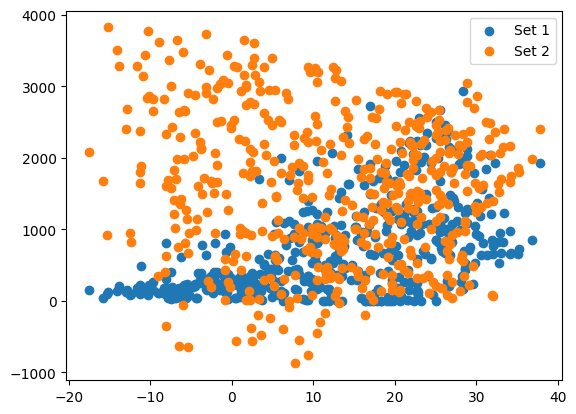

In [219]:
import matplotlib.pyplot as plt

best_ind = tools.selBest(pop, 1)[0]
print(best_ind)
print(toolbox.evaluate(best_ind, myNet))
myNet.setWeightsLinear(best_ind)
print(toolbox.evaluate(best_ind, myNet))

inputs = [[data['Hour'][i],data['Temp'][i], data['Windspeed'][i], data['HireAvailable'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i]] for i in range(len(data))]
# Assuming you have two sets of data:
x_values1 = data['Temp'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([1852.46104342]), array([3.65725615]), array([1693.59480057]), array([2193.93294556]), array([1336.04546807]), array([1168.59256745]), array([2219.57681428]), array([3306.25137782]), array([1014.22386538]), array([1182.68987907]), array([585.60766602]), array([2391.79147459]), array([425.26219442]), array([1806.07354954]), array([300.5582227]), array([177.43051776]), array([-451.12749564]), array([1644.08551249]), array([1485.85475023]), array([318.7550434]), array([3159.44494226]), array([1268.60524696]), array([2823.13088127]), array([-56.24102049]), array([1945.56006843]), array([1738.78393261]), array([1893.91806233]), array([2642.31489741]), array([1450.2090682]), array([82.06222335]), array([1615.38391624]), array([1474.46465312]), array([1019.08453842]), array([195.52999012]), array([431.34029787]), array([220.32383644]), array([942.12314283]), array([507.07679375]), array([1650.86945452]), array([1260.47878822]), array([788.59073684]), array([2057.03581565]), array([-238

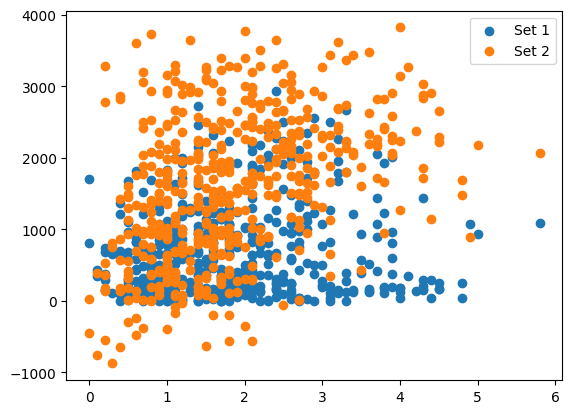

In [220]:
# Assuming you have two sets of data:
x_values1 = data['Windspeed'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Windspeed'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([1852.46104342]), array([3.65725615]), array([1693.59480057]), array([2193.93294556]), array([1336.04546807]), array([1168.59256745]), array([2219.57681428]), array([3306.25137782]), array([1014.22386538]), array([1182.68987907]), array([585.60766602]), array([2391.79147459]), array([425.26219442]), array([1806.07354954]), array([300.5582227]), array([177.43051776]), array([-451.12749564]), array([1644.08551249]), array([1485.85475023]), array([318.7550434]), array([3159.44494226]), array([1268.60524696]), array([2823.13088127]), array([-56.24102049]), array([1945.56006843]), array([1738.78393261]), array([1893.91806233]), array([2642.31489741]), array([1450.2090682]), array([82.06222335]), array([1615.38391624]), array([1474.46465312]), array([1019.08453842]), array([195.52999012]), array([431.34029787]), array([220.32383644]), array([942.12314283]), array([507.07679375]), array([1650.86945452]), array([1260.47878822]), array([788.59073684]), array([2057.03581565]), array([-238

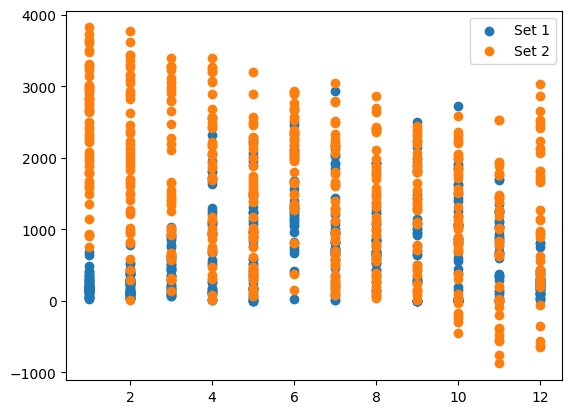

In [221]:
# Assuming you have two sets of data:
x_values1 = data['Month'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()